АНСАМБЛИ МОДЕЛЕЙ

# Домашняя работа

1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения:
    Jupyter notebook с кодом, комментариями и графиками

In [207]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from jupyterthemes import jtplot
from sklearn.metrics import auc, roc_curve, roc_auc_score
%matplotlib inline
jtplot.style()

In [208]:
df_house = pd.read_csv('house_train.csv')
df_house.shape

(1460, 81)

In [209]:
df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [210]:
df_house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [211]:
from sklearn.model_selection import StratifiedShuffleSplit

In [212]:
#Находим категориальные признаки
cat_feat = list(df_house.dtypes[df_house.dtypes == object].index)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
df_house[cat_feat] = df_house[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in df_house if f not in (cat_feat + ['Id', 'SalePrice'])]

# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = df_house[cat_feat].nunique()
print(cat_nunique)

# #Чтобы в разы не увеличивать число признаков при построении dummy,
# #будем использовать категориальные признаки с < 30 уникальных значений
# cat_feat = list(cat_nunique[cat_nunique < 30].index)

cat_feat = list(cat_nunique.index)

MSZoning          5
Street            2
Alley             3
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        5
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          5
BsmtCond          5
BsmtExposure      5
BsmtFinType1      7
BsmtFinType2      7
Heating           6
HeatingQC         5
CentralAir        2
Electrical        6
KitchenQual       4
Functional        7
FireplaceQu       6
GarageType        7
GarageFinish      4
GarageQual        6
GarageCond        6
PavedDrive        3
PoolQC            4
Fence             5
MiscFeature       5
SaleType          9
SaleCondition     6
dtype: int64


In [213]:
y = df_house['SalePrice']
X = df_house
X.drop('SalePrice', axis=1, inplace=True)
X.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,nan,Reg,Lvl,AllPub,...,0,0,nan,nan,nan,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,nan,Reg,Lvl,AllPub,...,0,0,nan,nan,nan,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,nan,IR1,Lvl,AllPub,...,0,0,nan,nan,nan,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,nan,IR1,Lvl,AllPub,...,0,0,nan,nan,nan,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,nan,IR1,Lvl,AllPub,...,0,0,nan,nan,nan,0,12,2008,WD,Normal


In [215]:
# Поделим на train и тест
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [216]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(X_train[cat_feat], columns=cat_feat)
dummy_test = pd.get_dummies(X_test[cat_feat], columns=cat_feat)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]

# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X_train = pd.concat([X_train[num_feat].fillna(-999),
                     dummy_train], axis=1)

X_test = pd.concat([X_test[num_feat].fillna(-999),
                     dummy_test], axis=1)


In [217]:
X_train.shape

(1168, 262)

In [218]:
X_test.shape

(292, 262)

3. Построить случайный лес, вывести важность признаков

In [219]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [220]:
# from sklearn.model_selection import cross_val_score

In [221]:
clf_rf = RandomForestRegressor()
# cross_val_score(clf_tree, X_train, y_train, cv=10)

In [222]:
depths = np.arange(1,10)
grid = {'max_depth': depths}#, 'max_features': features_num}
gridsearch = GridSearchCV(clf_rf, grid, scoring = 'r2', cv=10)

In [223]:
gridsearch

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [224]:
gridsearch.fit(X_train, y_train)

/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/darya/anaconda3/lib/python3.7/site-package

/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/darya/anaconda3/lib/python3.7/site-package

/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/darya/anaconda3/lib/python3.7/site-package

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [225]:
gridsearch.best_params_

{'max_depth': 6}

In [226]:
gridsearch.best_score_

0.8136854630980619

In [227]:
model = gridsearch.best_estimator_

In [228]:
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [116]:
# X_train.columns.tolist()

In [230]:
features = X_train.columns
importances = model.feature_importances_

indices = np.argsort(importances)
fi = pd.DataFrame([])
# plt.figure(figsize=(10,30))
fi['Feature Importances'] = importances[indices]
fi['Relative Importance'] = [features[i] for i in indices]
fi.tail(20)
# plt.title('Feature Importances')
# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), [features[i] for i in indices])
# plt.xlabel('Relative Importance')
# plt.show()

,Feature Importances,Relative Importance
242,0.003422,GarageYrBlt
243,0.003819,YearRemodAdd
244,0.005025,OpenPorchSF
245,0.005202,Fence_MnPrv
246,0.005694,Fireplaces
247,0.006387,WoodDeckSF
248,0.006439,TotRmsAbvGrd
249,0.007723,LotFrontage
250,0.008650,PoolArea
251,0.008729,BedroomAbvGr


In [231]:
fi = fi.sort_values(by=['Feature Importances'], ascending = False)
col = list(fi['Relative Importance'].head(10))

In [232]:
col

['OverallQual',
 'GrLivArea',
 'GarageCars',
 '1stFlrSF',
 'BsmtFinSF1',
 'TotalBsmtSF',
 'LotArea',
 'GarageArea',
 'YearBuilt',
 '2ndFlrSF']

In [233]:
gridsearch.fit(X_train[col], y_train)

/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/darya/anaconda3/lib/python3.7/site-package

/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/darya/anaconda3/lib/python3.7/site-package

/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/darya/anaconda3/lib/python3.7/site-package

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [234]:
gridsearch.best_score_

0.8133663117580514

In [235]:
model = gridsearch.best_estimator_

In [236]:
model.score(X_train[col], y_train)

0.9364805126828666

In [237]:
model.score(X_test[col], y_test)

0.8717823133728861

In [238]:
X_test_pred = model.predict(X_test[col])

4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения:
    Jupyter notebook с кодом, комментариями и графиками

In [239]:
from sklearn.preprocessing import StandardScaler

In [240]:
X_train.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'Functional_Typ', 'Foundation_CBlock', 'RoofStyle_Gambrel',
       'Exterior2nd_Wd Sdng', 'ExterCond_Gd', 'KitchenQual_Ex',
       'BsmtFinType2_Rec', 'CentralAir_Y', 'Exterior2nd_BrkFace',
       'SaleType_ConLD'],
      dtype='object', length=262)

In [241]:
scaler = StandardScaler()
scaler.fit(X_train)
columns = X_train.columns
X_train = pd.DataFrame(scaler.transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))
X_train.columns = columns
X_test.columns = columns

/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/darya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/home/darya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """


In [242]:
X_test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Functional_Typ,Foundation_CBlock,RoofStyle_Gambrel,Exterior2nd_Wd Sdng,ExterCond_Gd,KitchenQual_Ex,BsmtFinType2_Rec,CentralAir_Y,Exterior2nd_BrkFace,SaleType_ConLD
0,-0.887908,0.471945,-0.204026,-0.798371,-0.512891,-0.107970,-0.833312,0.355009,1.242773,-0.279177,...,0.274784,1.141818,-0.088121,-0.392620,-0.336811,-0.271163,-0.200178,0.269339,-0.128593,-0.077648
1,-0.190166,0.423559,-0.471853,-0.798371,1.262091,-1.401904,0.770963,-0.503290,-0.463324,3.969406,...,0.274784,-0.875797,-0.088121,2.546994,-0.336811,-0.271163,-0.200178,0.269339,-0.128593,-0.077648
2,-0.887908,0.464687,-0.159973,-1.521237,0.374600,-1.103304,-1.319456,-0.503290,0.531536,-0.279177,...,0.274784,1.141818,-0.088121,-0.392620,-0.336811,-0.271163,-0.200178,0.269339,-0.128593,-0.077648
3,0.740156,0.447752,-0.190727,-2.244102,-1.400382,-0.705170,-1.708372,-0.503290,-0.973844,-0.279177,...,0.274784,-0.875797,-0.088121,-0.392620,-0.336811,-0.271163,-0.200178,-3.712790,7.776483,-0.077648
4,-0.887908,0.491300,-0.037235,1.370227,-0.512891,1.185964,1.062649,1.887686,-0.901847,-0.279177,...,0.274784,-0.875797,-0.088121,-0.392620,-0.336811,-0.271163,-0.200178,0.269339,-0.128593,-0.077648


In [243]:
from sklearn.linear_model import LinearRegression
clf_lr = LinearRegression()

clf_lr.fit(X_train[col], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [244]:
from sklearn.ensemble import RandomForestRegressor

clf_rf = RandomForestRegressor(n_estimators=10, max_depth=5, min_samples_leaf=5)
clf_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [245]:
from sklearn.svm import SVR

clf_svr = SVR() #gamma='scale', C=1.0, epsilon=0.2)
clf_svr.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [246]:
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict(X_train.iloc[test_ind])
        meta_test += clf.predict(X_test)
    
    return meta_train, meta_test / stack_cv.n_splits

In [247]:
from sklearn.model_selection import StratifiedKFold

stack_cv = StratifiedKFold(n_splits=10, random_state=555)

meta_train = []
meta_test = []
col_names = []

print('LR features...')
meta_tr, meta_te = get_meta_features(clf_lr, X_train[col], y_train, X_test[col], stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('lr_pred')

print('RF features...')
meta_tr, meta_te = get_meta_features(clf_rf, X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')

print('SVR features...')
meta_tr, meta_te = get_meta_features(clf_svr, X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('svr_pred')

LR features...


/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


RF features...


/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


SVR features...


/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/darya/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarni

In [248]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)
X_meta_train.head()

,lr_pred,rf_pred,svr_pred
0,147116.968077,143839.689395,154988.535456
1,102163.471580,122807.964274,154985.070076
2,224041.820490,246434.624630,155016.790785
3,192423.607132,179544.290553,154992.889195
4,139757.085662,152035.743168,154986.083093


In [249]:
y_train.head()

269    148000
75      91000
564    268000
171    215000
371    134432
Name: SalePrice, dtype: int64

Стэкинг мета-признаков с помощью LR

Используем лин регрессию в качестве алгоритма второго уровня

In [250]:
clf_lr_meta = LinearRegression()
clf_lr_meta.fit(X_meta_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [251]:
y_pred_meta_test = clf_lr_meta.predict(X_meta_test)

clf_lr_meta.score(X_meta_test, y_test)

0.8564125881005427

Посмотрим на коэффициенты объединяющей линейной модели

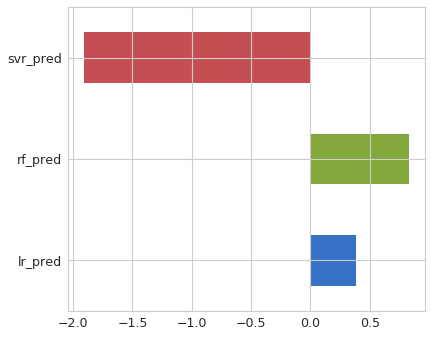

In [252]:
pd.Series(clf_lr_meta.coef_.flatten(), index=X_meta_train.columns).plot(kind='barh')

In [253]:
# Без rf_pred
meta_column = ['lr_pred', 'svr_pred']
clf_lr_meta.fit(X_meta_train[meta_column], y_train)
y_pred_meta_test = clf_lr_meta.predict(X_meta_test[meta_column])

clf_lr_meta.score(X_meta_test[meta_column], y_test) #R^2

0.8052827246103906

In [254]:
# lr_pred и rf_pred
meta_column = ['lr_pred', 'rf_pred']
clf_lr_meta.fit(X_meta_train[meta_column], y_train)
y_pred_meta_test = clf_lr_meta.predict(X_meta_test[meta_column])

clf_lr_meta.score(X_meta_test[meta_column], y_test) #R^2

0.8523400925616326

In [255]:
# svr_pred и rf_pred
meta_column = ['svr_pred', 'rf_pred']
clf_lr_meta.fit(X_meta_train[meta_column], y_train)
y_pred_meta_test = clf_lr_meta.predict(X_meta_test[meta_column])

clf_lr_meta.score(X_meta_test[meta_column], y_test) #R^2

0.8490606164503282

In [256]:
#Только rf_pred
meta_column = ['rf_pred']
clf_lr_meta.fit(X_meta_train[meta_column], y_train)
y_pred_meta_test = clf_lr_meta.predict(X_meta_test[meta_column])

clf_lr_meta.score(X_meta_test[meta_column], y_test) #R^2

0.8428101130815069

Любая модель с RandomForestRegressor показывает оценку лучше чем без.